In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [3]:
data_dir = "./data/WASP-77Ab"

In [18]:
from POSEIDON.utility import read_high_res_data_deprecate
import pickle

name = "IGRINS"
# data = read_high_res_data_deprecate(
#     "../high_res_experiments/data/WASP-77Ab/",
#     method="pca",
#     spectrum_type="emission",
# )
wl_grid, data_scale = pickle.load(
    open(
        "./data/WASP-77Ab/data_to_scale_with.pic",
        "rb",
    )
)
_, data_arr = pickle.load(open("./data/WASP-77Ab/PCA_matrix.pic", "rb"))
flux = data_scale + data_arr
phi = pickle.load(open("./data/WASP-77Ab/phi.pic", "rb"))
V_bary = pickle.load(open("./data/WASP-77Ab/V_bary.pic", "rb"))
flux[flux < 0] = 1e-4
add_high_res_data(
    data_dir,
    name,
    flux,
    wl_grid,
    phi,
    overwrite=True,
)

Overwriting data at ./data/WASP-77Ab/IGRINS/data_raw.hdf5


In [19]:
prepare_high_res_data(
    data_dir,
    name,
    "emission",
    "sysrem_2022",
    stack_order=False,
    overwrite=True,
    Print=True,
    niter=15,
    n_PC=5,
)

Overwriting data at ./data/WASP-77Ab/IGRINS/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations


In [64]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 0.91 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "H2O, CO"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["H2O"]  # H2O, CO as in Brogi & Line

high_res_params = ["K_p", "V_sys", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 50  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_H2O' 'K_p' 'V_sys'
 'log_a']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


In [65]:
# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")
param_species = ["H2O"]
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-4]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [0.2, 0.1, 0.17, -1.39, 1, 1500]
)  # a1, a2, log_P1, log_P2, log_P3, T_top
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1e-5
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="direct_emission",
)

In [66]:
def cross_correlate(
    Kp_range, Vsys_range, RV_range, wl, planet_spectrum, data, Print=True
):
    if Print:
        time0 = time.time()
    uncertainties = data["uncertainties_processed"]
    uncertainties = np.ones_like(uncertainties)
    residuals = data["residuals"]
    phi = data["phi"]
    wl_grid = data["wl_grid"]
    # transit_weight = data["transit_weight"]
    # max_transit_depth = np.max(1 - transit_weight)

    norder, nphi, npix = residuals.shape
    CCF_Kp_Vsys = np.zeros((len(Kp_range), len(Vsys_range)))

    nRV = len(RV_range)
    CCF_phase_RV = np.zeros((nphi, nRV))
    models_shifted = np.zeros((nRV, norder, npix))
    for RV_i, RV in enumerate(RV_range):
        # Looping through each order and computing total log-L by summing logLs for each obvservation/order
        for order_i in range(norder):
            wl_slice = wl_grid[order_i]  # Cropped wavelengths
            delta_lambda = RV * 1e3 / constants.c
            wl_shifted = wl * (1.0 + delta_lambda)
            F_p = np.interp(wl_slice, wl_shifted, planet_spectrum)
            models_shifted[RV_i, order_i] = F_p  # choose not to filter

    # negative of transmission spectrum gives absorption. Adding or multiplying constant does not change the CCF
    # m = -models_shifted
    m = models_shifted
    # already minus mean in prepare_data

    for phi_i in range(nphi):
        for RV_i in range(nRV):
            f = residuals[:, phi_i, :]
            CCF = np.sum(f[:, :] * m[RV_i, :, :] / uncertainties[:, phi_i, :] ** 2)
            CCF_phase_RV[phi_i, RV_i] += CCF

    # CCF_phase_RV = (1 - transit_weight[:, None]) * CCF_phase_RV

    for Kp_i, Kp in enumerate(Kp_range):
        for phi_i in range(nphi):
            RV = Kp * np.sin(2 * np.pi * phi[phi_i]) + Vsys_range + V_bary[phi_i]
            CCF_Kp_Vsys[Kp_i] += np.interp(RV, RV_range, CCF_phase_RV[phi_i])
    if Print:
        time1 = time.time()
        print("Cross correlation took {} seconds".format(time1 - time0))
    return CCF_Kp_Vsys, CCF_phase_RV

In [67]:
from PyAstronomy import pyasl
import POSEIDON

name = "IGRINS"
data = POSEIDON.high_res.read_high_res_data(data_dir, names=[name])
# spectrum = np.load("./data/WASP-76b-MAROON/" + "models/Fe.npy")
# model_wave = np.load("./data/WASP-76b-MAROON/" + "models/wave.npy")
model_wave = wl
# model_wave = pyasl.vactoair2(model_wave * 1e4) / 1e4

In [69]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(0, 301, 1)
Vsys_range = np.arange(-100, 101, 1)
RV_range = np.arange(-100, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        model_wave,
        gaussian_filter1d(spectrum, 3),
        # spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 28.53154730796814 seconds


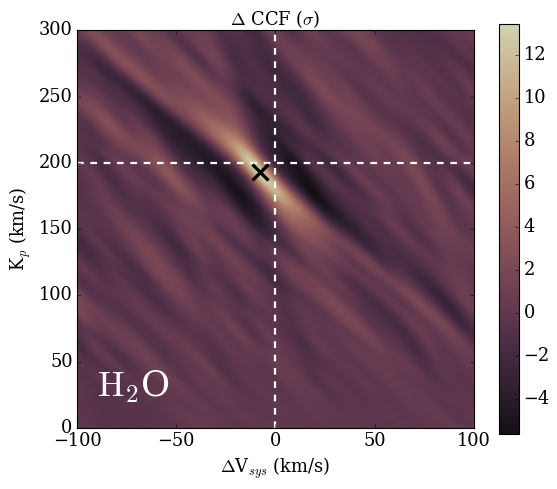

In [76]:
import matplotlib
import POSEIDON.visuals

params = {
    "legend.fontsize": 14,
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize": 16,
}
matplotlib.rcParams.update(params)
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    r"$\rm{H_2}$O",
    200,
    Vsys=0,
    RM_mask_size=20,
    plot_label=True,
    file_path="./CC_output/WASP77_CCF_H2O.pdf",
    savefig=True,
    plot_slice=False,
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)

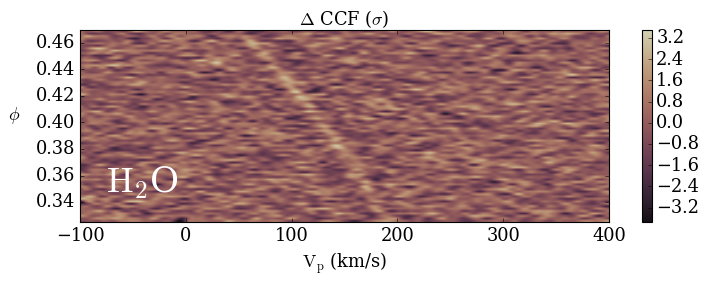

In [77]:
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0),
    r"$\rm{H_2}$O",
    plot_label=True,
    save_path="./CC_output/WASP77_CCF_phase_H2O.pdf",
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)